In [1]:
# Run this cell only if you are running this in google colab
!git clone https://github.com/codyarvonen/2048
import sys
sys.path.append('/content/2048')

Cloning into '2048'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 126 (delta 68), reused 80 (delta 32), pack-reused 0
Receiving objects: 100% (126/126), 1.37 MiB | 2.08 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [1]:
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from game import Game
from direction import Direction

pygame 2.3.0 (SDL 2.24.2, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def play_random_game(save: bool=False):
    # Initialize the random game
    random_seed = random.randint(0, 2**32 - 1)
    random_game = Game(seed=random_seed, iterative_mode=True, save_game=save, visualize=False)
    board = random_game.init_board()

    # print(random_seed)

    # Step through the game loop
    total_score = 0
    game_over = False
    count = 0
    while not game_over:
        action = random.choice(list(Direction))
        new_board, reward, game_over = random_game.step(board, action)
        total_score += reward.action_score
        count += 1
        board = new_board.copy()

    if save:
        random_game.history.final_board = board
        random_game.store_history('test_random_games')

    return board, total_score, count

In [3]:
def print_game_stats_from_file(file: str):
    with open(file, 'rb') as f:
        game_history = pickle.load(f)
        print(game_history.final_board)
        # Game(seed=game_history.seed, command_list=game_history.action_list).run() 

In [4]:
def plot_score_dist(scores):
    # Score distribution
    plt.hist(scores, bins = 100)
    plt.title("Total score distribution")
    plt.xlabel("Total Score")
    plt.ylabel("Frequency")
    plt.show()

def plot_best_tile_dist(tiles):
    # Best tile distribution
    max_power = int(math.log(max(tiles), 2)) + 1
    min_power = int(math.log(min(tiles), 2))
    unique, counts = np.unique(tiles, return_counts=True)
    plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
    plt.title("Best tile distribution")
    plt.xlabel("Best tile")
    plt.ylabel("Frequency")
    plt.show()

**Baseline**

In [5]:

# Execute the baseline (games with only random actions)

baseline_episodes = 500
baseline_scores = []
baseline_best_tiles = []
save_random_games = False

iterations = []

for episode in tqdm(range(baseline_episodes), total=baseline_episodes):
    board, score, num_iterations = play_random_game(save=save_random_games)
    baseline_scores.append(score)
    baseline_best_tiles.append(np.amax(board))
    iterations.append(num_iterations)

np.mean(np.array(iterations))


100%|██████████| 500/500 [00:12<00:00, 38.58it/s]


140.118

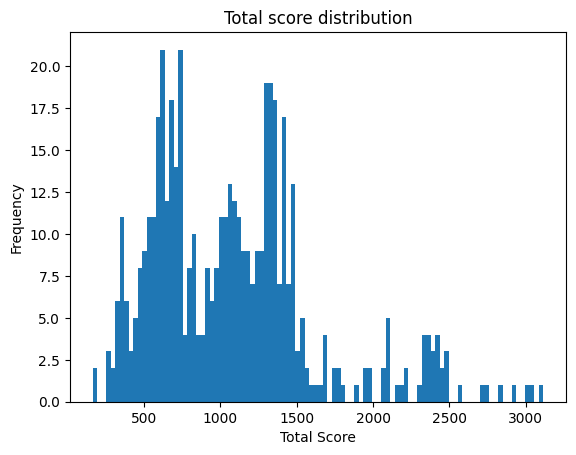

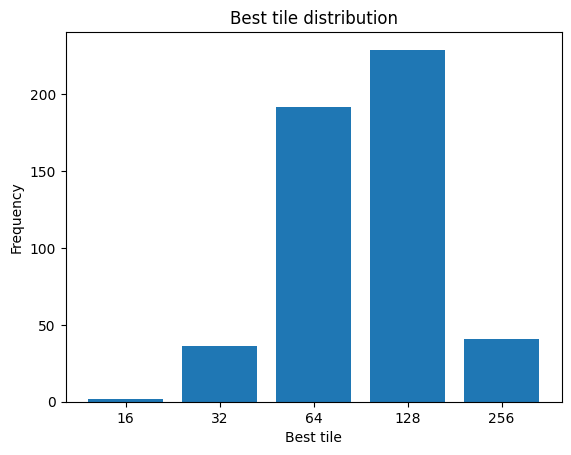

In [6]:
# Visualize the baseline performance
plot_score_dist(baseline_scores)
plot_best_tile_dist(baseline_best_tiles)

**Training**

In [5]:
from memory import ReplayMemory, Experience
from qnet import QNet, QNetConv
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# TODO: refactor constants
MEM_CAPACITY = 50000
NUM_STATES = 16
NUM_ACTIONS = 4
LEARNING_RATE = 5e-5
EPISODES = 15000
EPSILON_START = 0.9
EPSILON_END = 0.01
EPSILON_DECAY = 0.999
UPDATE_TARGET = 25
BATCH_SIZE = 128
LEARN_ITERATIONS = 50
GAMMA = 0.99

# TODO: decay the LR?

load_model = True
use_conv_model = False
save_episodes = False

# Initialize replay memory
replay_memory = ReplayMemory(MEM_CAPACITY)

# Initialize action-value function and target action-value function
if use_conv_model:
    qnet = QNetConv(NUM_STATES, NUM_ACTIONS, device).to(device)
    qnet_target = QNetConv(NUM_STATES, NUM_ACTIONS, device).to(device)
else:
    qnet = QNet(NUM_STATES, NUM_ACTIONS, device).to(device)
    qnet_target = QNet(NUM_STATES, NUM_ACTIONS, device).to(device)

epsilon = EPSILON_START

if load_model:
    qnet.load_state_dict(torch.load("75k_iterations.pth", map_location=torch.device(device)))
    qnet_target.load_state_dict(torch.load("75k_iterations.pth", map_location=torch.device(device)))
    epsilon = EPSILON_END

qnet.train()
qnet_target.eval()

# Initialize optimization functions
criterion = nn.MSELoss()
optimizer = optim.Adam(qnet.parameters(), lr=LEARNING_RATE)

# Iterate through the episodes
iterations = 0
trained_scores = []
trained_best_tiles = []
losses = []
pbar = tqdm(range(EPISODES), total=EPISODES, desc="Training", leave=False)
for episode in pbar:
    # Initialize game for episode
    episode_game = Game(seed=random.randint(0, (2**32)-1), iterative_mode=True, save_game=save_episodes, visualize=False)

    # Initialize the board
    board = episode_game.init_board()

    # Step through the episode
    episode_score = 0
    episode_done = False
    is_invalid = False
    invalid_index = 1
    while not episode_done:

        # With probability epsilon select a random action, else choose from policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(list(Direction))
            is_invalid = False
            invalid_index = 1
        else:
            qnet.eval()
            with torch.no_grad():
                if is_invalid:
                    if invalid_index == 5:
                        invalid_index = 1
                    elif invalid_index > 5:
                        raise Exception("invalid index is greater than 5...")  
                    _, indices = torch.topk(qnet(board), k=invalid_index)
                    action = indices[0][invalid_index-1]
                    is_invalid = False
                else:
                    action = torch.argmax(qnet(board))
                action = Direction(action.item())
            qnet.train()
        
        # Execute action and observe reward
        result = episode_game.step(board, action)
        
        reward = result[1].get_total_reward()
        episode_score += result[1].action_score
        
        replay_memory.memory.append(Experience(board, action, reward, result[0]))

        if np.array_equal(board, result[0]):
            invalid_index += 1
            is_invalid = True
        else:
            invalid_index = 1
            board = result[0]

        episode_done = result[2]

        if episode_done:
            # Optimize model if 
            if len(replay_memory) > BATCH_SIZE:
                for i in range(LEARN_ITERATIONS):
                    experiences = replay_memory.sample(BATCH_SIZE)
                    states = []
                    actions = []
                    rewards = []
                    next_states = []
                    for experience in experiences:
                        states.append(experience.state)
                        actions.append(experience.action)
                        rewards.append(experience.reward)
                        next_states.append(experience.next_state)
                                        

                    states = np.array(states)
                    actions = torch.tensor([act.value for act in actions]).unsqueeze(1).to(device)
                    rewards = torch.tensor(rewards).to(device)
                    next_states = np.array(next_states)
                    
                    # Get the Q values for each action
                    q_vals = qnet(states)

                    # Gather the Q values for the action that was taken
                    estimated_actions = torch.gather(q_vals, 1, actions)

                    expected_actions = qnet_target(next_states).max(1)[0].detach().float()
                    expected_actions = (expected_actions * GAMMA) + rewards
                    expected_actions = expected_actions.float()

                    loss = criterion(estimated_actions, expected_actions.unsqueeze(1))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # losses.append(loss.detach())

    best_tile = np.amax(board)
    trained_scores.append(episode_score)
    trained_best_tiles.append(best_tile)

    # Update epsilon
    epsilon = epsilon * EPSILON_DECAY
    epsilon = max(epsilon, EPSILON_END)

    if save_episodes:
        episode_game.store_history('training_episodes_2')

    # Every C steps reset target model
    if episode % UPDATE_TARGET == 0:
        qnet_target.load_state_dict(qnet.state_dict())
        qnet.train()

    mem_conc = [x.reward for x in replay_memory.memory if x.reward == -10]

    pbar.set_description(f"best_tile: {best_tile}, avg_best_tile: {np.mean(np.array(trained_best_tiles))}, replay_memory: {len(mem_conc)/len(replay_memory)}")
    pbar.update(1)

# pbar.close()

# TODO: add penalty for losing the game


KeyboardInterrupt: 

In [8]:
# Save the model
torch.save(qnet.state_dict(), "87k_iterations.pth")

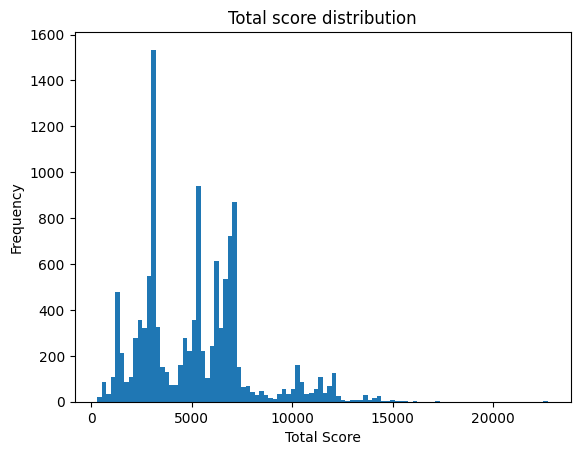

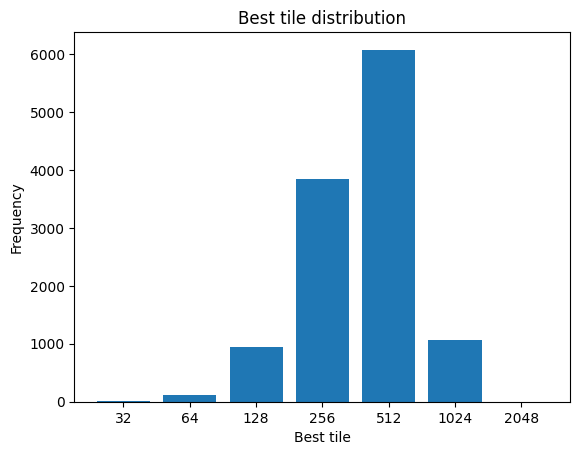

In [9]:
# Visualize the performance during training
plot_score_dist(trained_scores)
plot_best_tile_dist(trained_best_tiles)

In [ ]:
# Run this cell to test how many episodes it will take for epsilon to decay

EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 0.999

count = 0
eps = EPS_START
while (eps := eps * EPS_DECAY) > EPS_END:
    count += 1

print(count)

4497


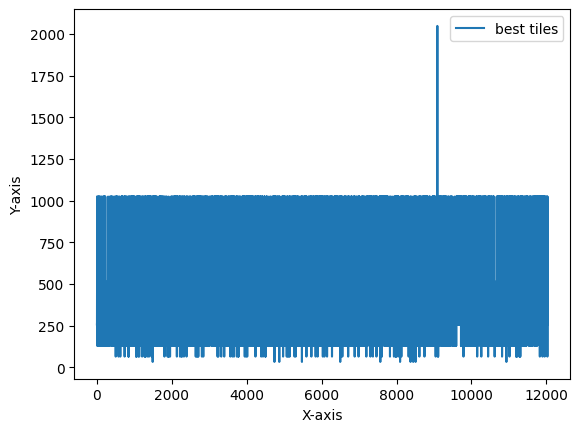

In [10]:
# PLOT METRIC OVER TIME DURING TRAINING

# loss_vals = [item.detach().cpu().numpy().tolist() for item in losses]

plt.plot(trained_best_tiles)
# plt.plot(trained_scores)
# plt.plot(loss_vals)

# add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(['best tiles', 'score', 'losses'])

# display the plot
plt.show()


In [11]:
def play_game_from_model(save: bool=False):
    # Initialize the random game
    random_seed = random.randint(0, 2**32 - 1)
    trained_game = Game(seed=random_seed, iterative_mode=True, save_game=save, visualize=False)
    trained_board = trained_game.init_board()

    # Step through the game loop
    total_score = 0
    game_over = False
    step_count = 0
    invalid_count = 0
    qnet.eval()
    is_invalid = False
    invalid_index = 1
    while not game_over:
        trained_action = None
        with torch.no_grad():
            vals = qnet(trained_board)
            if is_invalid:
                _, indices = torch.topk(vals, k=invalid_index)
                trained_action = indices[0][invalid_index-1]
                is_invalid = False
            else:
                trained_action = torch.argmax(vals)
            trained_action = Direction(trained_action.item())
        new_trained_board, reward, game_over = trained_game.step(trained_board, trained_action)

        if np.array_equal(new_trained_board, trained_board):
            invalid_count += 1
            invalid_index += 1
            is_invalid = True
        else:
            invalid_index = 1
            total_score += reward.action_score
            step_count += 1
            trained_board = new_trained_board.copy()

    if save:
        trained_game.history.final_board = trained_board
        trained_game.store_history('test_trained_games')

    qnet.train()
    
    return trained_board, total_score, step_count, invalid_count

In [12]:
# Evaluate the model after training

evaluated_episodes = 1000
evaluated_scores = []
evaluated_best_tiles = []
save_evaluated_games = False

iterations = []
invalids = []

for episode in tqdm(range(evaluated_episodes), total=evaluated_episodes):
    board, score, num_iterations, num_invalid = play_game_from_model(save=save_evaluated_games)
    evaluated_scores.append(score)
    evaluated_best_tiles.append(np.amax(board))
    iterations.append(num_iterations)
    invalids.append(num_invalid)

np.mean(np.array(iterations))

100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s]


414.206

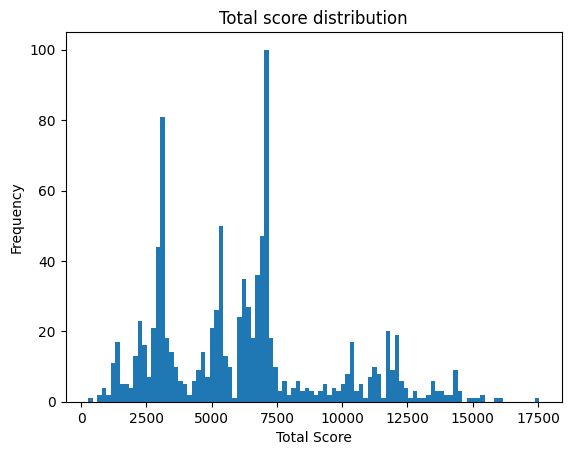

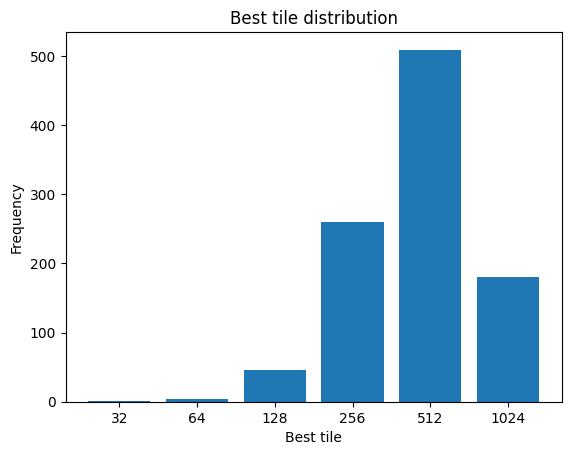

In [13]:
# Visualize the performance of the trained model
plot_score_dist(evaluated_scores)
plot_best_tile_dist(evaluated_best_tiles)